# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection** 
***


### Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
import math
from scipy.signal import find_peaks_cwt

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
#import sklearn
#print('My scikit-learn version is {}.'.format(sklearn.__version__))

## Detect and tracking vehicles

### Functions

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)

        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))#True
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)#True
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # heatmap[heatmap > threshold] = 1
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, boxes

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, out = 'boxes'):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    box_list = []
    
    if xstart is None:
        xstart = 0
    if xstop is None:
        xstop = img.shape[1]
    if ystart is None:
        ystart = img.shape[0]/2
    if ystop is None:
        ystop = img.shape[0]-20
    
    for scale in scale_list:
        img_tosearch = img[ystart:ystop,xstart:xstop,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb') # RGB2YCrCb RGB2HSV
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    #print('find')
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)

                    box_list.append(( (xbox_left+xstart, ytop_draw+ystart),
                                     (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart) ))

                    #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                    #              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    if out == 'boxes':
        return box_list
    else:
        heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)

        #np.savetxt("foo.csv", heat[390:660,780:1200], delimiter=",")

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)

        return draw_img, box_list, labels, heatmap
    

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Load data and train the model

In [10]:
# Read in cars and notcars
imagesCAR = glob.glob('vehicles/vehicles/*/*.png')
cars = []
for image in imagesCAR:
    cars.append(image)

imagesNONCAR = glob.glob('non-vehicles/non-vehicles/*/*.png')
notcars = []
for image in imagesNONCAR:
    notcars.append(image)
        
print("Training data size ")
      
print("images of cars: ", len(cars), "; images of non-cars: ", len(notcars))

Training data size 
images of cars:  8792 ; images of non-cars:  8968


In [11]:
# Use data to train the classifier or load the classifier
train_model = 1 # 0 for load classifier and 1 for traing classifier

In [12]:
if train_model == 1:
    print("Training ...")

    ### Tweak these parameters and see how the results change.
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True  # HOG features on or off
    
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 8000)

    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.25, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample

    # Save the classification result for later use
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["color_space"] = color_space

    #if orient == 9
    pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )
    
else:
    # load the classifier and parameters
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]

Training ...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
7.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


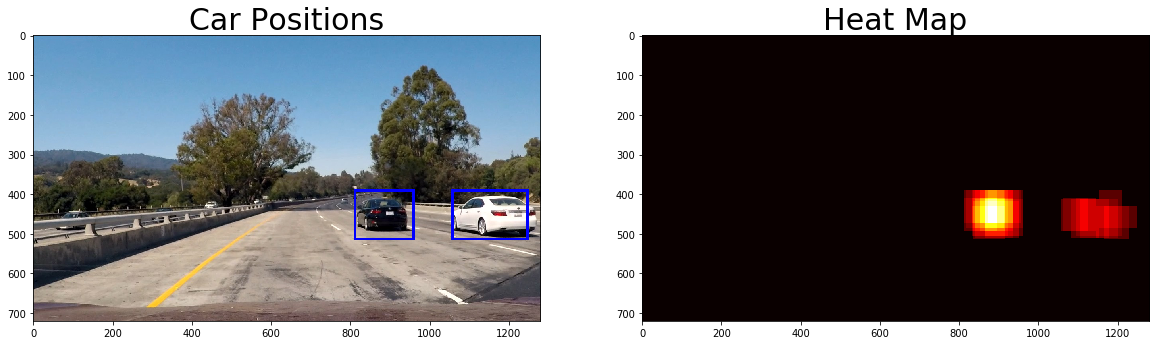

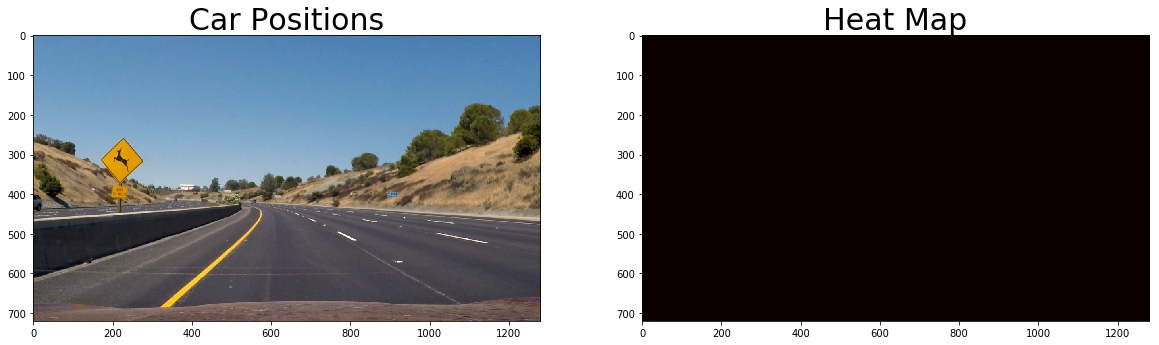

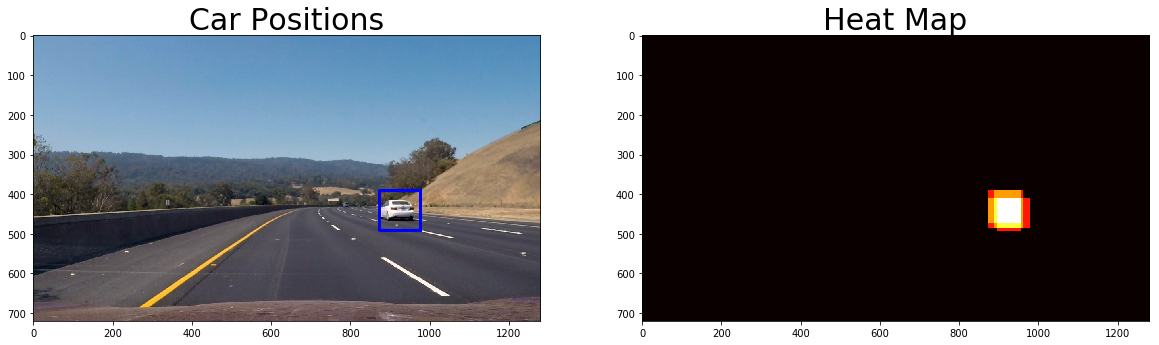

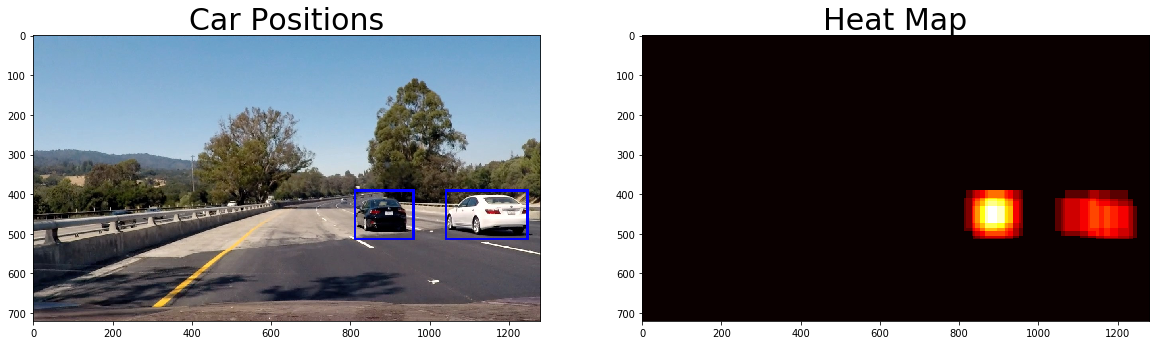

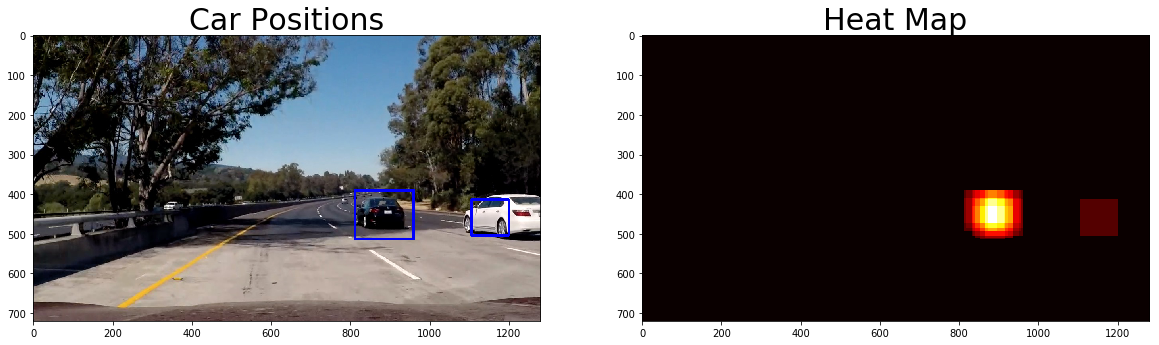

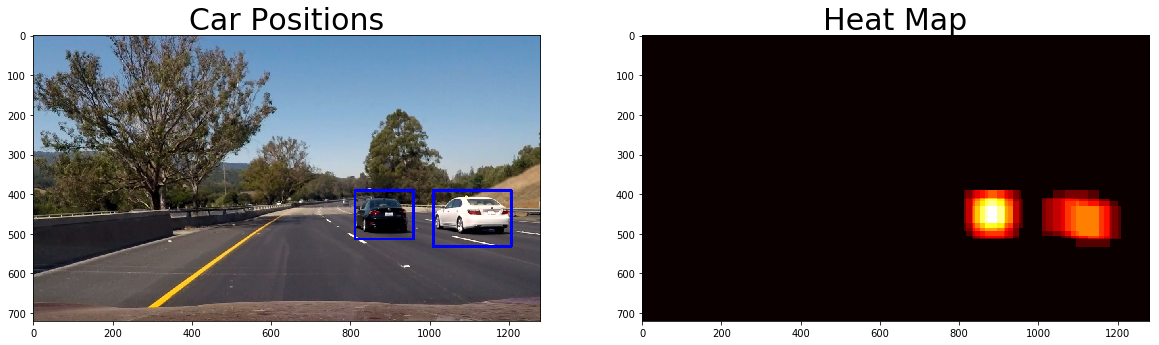

In [13]:
ystart = 390
ystop = 660
xstart = None
xstop = None
outputs = 'boxes'
scale_list = [1.3,1.5,1.8] #[1.2,1.6,0.8]#[1, 1.2, 1.5, 1.7] out_img, box_list, labels, heatmap

for i in range(1,7):
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)

    box_list = find_cars(image, xstart, xstop, ystart, ystop, scale_list, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, out = outputs)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, _ = draw_labeled_bboxes(np.copy(image), labels)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(draw_img)
    ax1.set_title('Car Positions', fontsize=30)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    #print("car number: ", labels[1])
    #cv2.imwrite('detect_heatmap.jpg',f)


### Test tracking: search for vehicles in regions of interest (ROIs), which are the pixels where vehicles are detected in previous frames

2


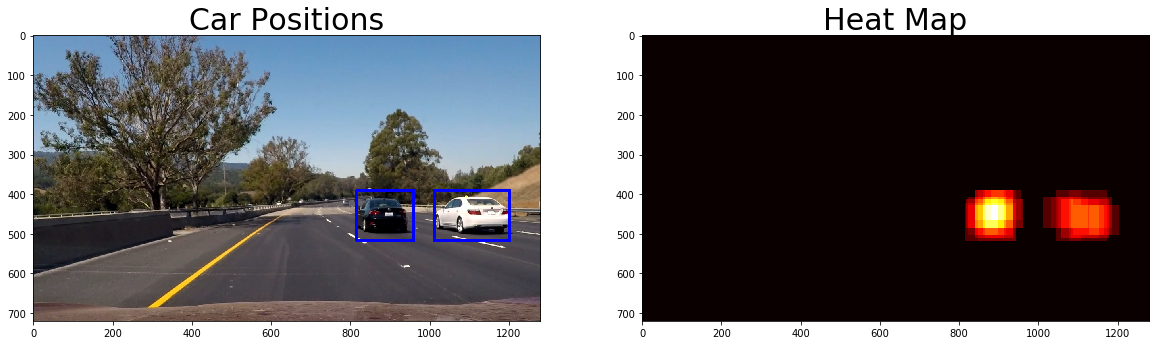

In [14]:
fname = 'test_images/test6.jpg'
image = mpimg.imread(fname)

ystart = 390
ystop = 660
xstart = None
xstop = None
outputs = 'boxes'
scale_list = [1.5]

box_list = find_cars(image, xstart, xstop, ystart, ystop, scale_list, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, out = outputs)
    
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
#draw_img = draw_labeled_bboxes(np.copy(image), labels)

vehicle_num = labels[1]
print(vehicle_num)

offset = 200

for car_number in range(1, labels[1]+1):
    # Find pixels with each car_number label value
    nonzero = (labels[0] == car_number).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    box_center = (np.int((np.min(nonzerox) + np.max(nonzerox) )/2), 
                  np.int( (np.min(nonzeroy) + np.max(nonzeroy))/2))
    
    #print(box_center)
    
    
    xstart = max(box_center[0]-offset,0)
    xstop = min(box_center[0]+offset,image.shape[1])
    ystart = max(box_center[1]-offset, 390)
    ystop = min(box_center[1]+offset,660)
    scale_list = [1.2, 2]
    box_list_track = find_cars(image, xstart, xstop, ystart, ystop, scale_list, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, out = outputs)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list_track)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img,_ = draw_labeled_bboxes(np.copy(image), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=30)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=30)
#print("car number: ", labels[1])

In [15]:
class Tracker():
    def __init__(self):
        self.vehicle_num = 0
        self.vehicle_center_pix = np.array([None]*10)
        self.first_frame = True
        
        #Previous frames heatmaps
        self.heatmap = np.array([None]*12)
        #first frame 
        self.smoothened = 12
        
global vehicle_detected
vehicle_detected = Tracker()

### My vehicle detection pipeline

In [16]:
search_offset_x = 80
search_offset_y = 150
outputs = 'boxes'

def vechicle_detection(image):
    
    draw_img = np.copy(image)
    
    ystart = 390
    ystop = 660
    xstart = None
    xstop = None
    if vehicle_detected.vehicle_num == 0:
        scale_list = [1.3,1.5,1.8]#,1.8
    else:
        scale_list = [1.5]
    box_list = find_cars(image, xstart, xstop, ystart, ystop, scale_list, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, out = outputs)
                  
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    if vehicle_detected.first_frame == False:
        # not the first frame
        
        # already detected
        prev_car_num = vehicle_detected.vehicle_num
        prev_car_center = vehicle_detected.vehicle_center_pix

        if prev_car_num > 0:
            
            for car_number in range(0, prev_car_num):

                xstart = max(prev_car_center[car_number][0]-search_offset_x,0)
                xstop = min(prev_car_center[car_number][0]+search_offset_x,image.shape[1])
                ystart = max(prev_car_center[car_number][1]-search_offset_y, 390)
                ystop = min(prev_car_center[car_number][1]+search_offset_y,660)
                
                if prev_car_center[car_number][1] < 500:
                    scale_list = [1.3,1.8]
                else:
                    scale_list = [1.8]
                    
                
                box_list_track = find_cars(image, xstart, xstop, ystart, ystop, scale_list, 
                                        svc, X_scaler, orient, pix_per_cell, 
                                        cell_per_block, spatial_size, hist_bins, out = outputs)
                
                # Add heat to each box in box list
                heat = add_heat(heat,box_list_track)

            
    # Apply threshold to help remove false positives
    # heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    if vehicle_detected.first_frame == True:
        applied_threshold = apply_threshold(np.copy(heatmap), 1)
        #make the history same as the first frame
        vehicle_detected.heatmap = np.array([applied_threshold] * vehicle_detected.smoothened)
        vehicle_detected.first_frame = False
        labels = label(applied_threshold)
    else:    
        #look into previous frames   
        vehicle_detected.heatmap[0:-1] = vehicle_detected.heatmap[1:]
        vehicle_detected.heatmap[-1] = heatmap
        new_previous_frame_threshold = vehicle_detected.heatmap.sum(axis=0)

        applied_threshold = apply_threshold(np.copy(new_previous_frame_threshold), 16)
        labels = label(applied_threshold)
        
    
    vehicle_detected.vehicle_num = labels[1]
        
    if vehicle_detected.vehicle_num > 0:
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            box_center = (np.int((np.min(nonzerox) + np.max(nonzerox))/2), 
                          np.int((np.min(nonzeroy) + np.max(nonzeroy))/2))

            vehicle_detected.vehicle_center_pix[car_number-1] = box_center
    
    
    draw_labeled, bbox = draw_labeled_bboxes(np.copy(image), labels)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Number of cars detected: {}".format(int(vehicle_detected.vehicle_num))
    cv2.putText(draw_labeled,text,(50,100), font, 1,(255,255,255),2)
    
    #bias the position of the detected region by adding +1 to it
    vehicle_detected.heatmap[-1] = add_heat(vehicle_detected.heatmap[-1], bbox)

    return draw_labeled

In [17]:
vehicle_detected = Tracker()
output = 'test_video_output.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4") # solidWhiteRight challenge solidYellowLeft
video_clip = clip1.fl_image(vechicle_detection) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 18.8 s, sys: 264 ms, total: 19.1 s
Wall time: 18.4 s


In [18]:
HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(output))

In [19]:
vehicle_detected = Tracker()
output = 'project_video_output_03.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(7,11) # solidWhiteRight challenge solidYellowLeft
video_clip = clip1.fl_image(vechicle_detection) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_03.mp4
[MoviePy] Writing video project_video_output_03.mp4


 99%|█████████▉| 100/101 [00:42<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_03.mp4 

CPU times: user 46 s, sys: 736 ms, total: 46.7 s
Wall time: 43.6 s


In [20]:
HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(output))

## Camera Calibration

In [21]:
# prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        #write_name_corner = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name_corner, img)
        
        #cv2.imshow('img', img)
        #cv2.waitKey(700)

#cv2.destroyAllWindows()

### Visualize the calibrated images (chessboard images)

#### Read in images, Distortion correction

In [22]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('calibrated1.jpg',dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion


### Define Functions

In [23]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [24]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [25]:
# Calculate directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    else:
        print('the second argument should be either x or y')
    
    binary_grad = np.zeros_like(scaled_sobel)
    binary_grad[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_grad

In [26]:
# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))

    
    binary_mag = np.zeros_like(scaled_sobel)
    binary_mag[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_mag

In [27]:
# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobely = np.absolute(sobely)

    dir_grad = np.arctan2(abs_sobely, abs_sobelx)

    binary_dir = np.zeros_like(dir_grad)
    binary_dir[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return binary_dir

In [28]:
def hls_select(img, thresh_S=(90, 255)):
    #, thresh_H = (15, 100)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # H = hls[:,:,0]
    # L = hls[:,:,1]
    S = hls[:,:,2]

    binary_S = np.zeros_like(S)
    binary_S[(S > thresh_S[0]) & (S <= thresh_S[1])] = 1
    
    
    #binary_H = np.zeros_like(H)
    #binary_H[(H > thresh_H[0]) & (H <= thresh_H[1])] = 1
    
    #binary = np.zeros_like(S)
    #binary[(binary_S == 1) | (binary_H == 1)] = 1
    
    return binary_S

### Add the following function in color thresholding

An idea for more robust extraction is to try color thresholding in all the RGB, HSV and HSL channels for your yellows and whites! By using color thresholding you are able to make the lane detection more robust by relying less on gradients for good results! Furthermore, thresholding is a lot faster in terms of processing than gradients!

In [29]:
def yellow_white_select(img):
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    
    white_3 = cv2.inRange(img, (200,200,200), (255,255,255))

    return yellow, white, white_2, white_3

In [30]:
def gray_select(img, thresh=(180, 255)):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

### Color & Gradient threshold

In [31]:
def pipeline(img):
    # img = cv2.undistort(img, mtx, dist, None, mtx)
    # Choose a blue kernel
    blur_kernel_size = 5
    img = gaussian_blur(img, blur_kernel_size)
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.6, 1.3))
    hls_binary = hls_select(img, thresh_S=(90, 255)) # ,  thresh_H = (15, 100)
    
    yellow, white, white_2, white_3 = yellow_white_select(img)
    
    combined = np.zeros_like(dir_binary)
    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1

    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1) | (yellow == 1) | (white == 1) | (white_2 == 1) | (white_3 == 1)] = 1
    
    
    # add a mask
    imshape = combined.shape
    # vertices = np.array([[(0,imshape[0]),(imshape[1]/2,imshape[0]/2+40), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # change area of interest
    # vertices = np.array([[(0,imshape[0]),(400,imshape[0]/3*2), (imshape[1]-400,imshape[0]/3*2), (imshape[1],imshape[0])]], dtype=np.int32)
    
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-140,imshape[0]/2+80), (imshape[1]/2+140,imshape[0]/2+80), (imshape[1],imshape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(combined, vertices)
    
    return masked_edges

### Perspective Transform

You would like to pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above. 
The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

In [32]:
# area_of_interest = [[170,720],[540,480],[750,480],[1140,720]]

area_of_interest = [[160,720],[590,440],[690,440],[1120,720]]

In [33]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Choose an offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, img_size[1]-offset2], [offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

In [34]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #x values for detected line pixels
        self.allx = None  
        
        #x values in windows
        self.windows = np.ones((3,12))*-1

### Calculated the radius of curvature of the lane and the position of the vehicle with respect to center

#### Revise the measurement of curvature

Here are some things to try:

* Try fitting the middle of the polynomial with this change: ```y_eval = np.max(ploty)/2```
* Be sure to convert `y_eval` to meters in your `curverad`
* Be on the look out for radius of curvatures between 400-1500 meters for you curves and values higher than 2500 m for when the road appears to be straight.

In [35]:
def find_curvature(yvals, fitx, image):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/image.shape[0] # 720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    # middle
    y_eval1 = np.max(yvals)/2-60
    y_eval2 = np.max(yvals)/2
    y_eval3 = np.max(yvals)/2+60
    
    curverad1 = ((1 + (2*fit_cr[0]*y_eval1 + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
    curverad2 = ((1 + (2*fit_cr[0]*y_eval2 + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
    curverad3 = ((1 + (2*fit_cr[0]*y_eval3 + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
    
    #print(curverad1, curverad2)
    
    curverad = np.mean([curverad1, curverad2, curverad3])
    
    return curverad

def find_position(pts, image):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image.shape[1]/2
    
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > image.shape[0]-55)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > image.shape[0]-55)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

In [36]:
def find_peaks(image, y_window_top, y_window_bottom, x_left, x_right):
    # Find the historgram from the image inside the window
    histogram = np.sum(image[y_window_top:y_window_bottom,:], axis=0)
    # Find the max from the histogram
    if len(histogram[int(x_left):int(x_right)])>0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2  

In [37]:
def sanity_check(lane, curverad, fitx, fit):       
    # Sanity check for the lane
    if lane.detected: # If lane is detected
        # If sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:        
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            
        # If sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        # If lane was not detected and no curvature is defined
        if lane.radius_of_curvature: 
            if abs(curverad / lane.radius_of_curvature - 1) < 1:            
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                
            else:
                lane.detected = False
                fitx = lane.allx      
        # If curvature was defined
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

In [38]:
# Sanity check for the direction
def sanity_check_direction(right, right_pre, right_pre2):
    # If the direction is ok then pass
    if abs((right-right_pre) / (right_pre-right_pre2) - 1) < .33:
        return right
    # If not then compute the value from the previous values
    else:
        return right_pre + (right_pre - right_pre2) # or (right_pre + right_pre2)/2

In [39]:
# find_lanes function will detect left and right lanes from the warped image.  
def find_lanes(n, image, x_window, lanes, left_lane_x, left_lane_y, right_lane_x, right_lane_y, window_ind):
    # 'n' windows will be used to identify peaks of histograms
    # Set index1. This is used for placeholder.
    index1 = np.zeros((n+1,2))
    index1[0] = [image.shape[1]/4-35, image.shape[1] - 200]# [300, 1100]
    index1[1] = [image.shape[1]/4-35, image.shape[1] - 200]# [300, 1100]
    # Set the first left and right values
    left, right = [image.shape[1]/4-35, image.shape[1] - 200]# (300, 1100)
    # Set the center
    center = image.shape[1]/2+50 # 700
    # Set the previous center
    center_pre = center
    # Set the direction
    direction = 0
    
    for i in range(n-1):
        # set the window range.
        y_window_top = np.int(image.shape[0] - image.shape[0]/n*(i+1))
        y_window_bottom = np.int(image.shape[0] - image.shape[0]/n*i)
        # If left and right lanes are detected from the previous image
        if (left_lane.detected==False) and (right_lane.detected==False):
            # Find the historgram from the image inside the window
            left  = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,0]-200, index1[i+1,0]+200)
            right = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,1]-200, index1[i+1,1]+200)
            # Set the direction
            left  = sanity_check_direction(left, index1[i+1,0], index1[i,0])
            right = sanity_check_direction(right, index1[i+1,1], index1[i,1]) 
            # Set the center
            center_pre = center
            center = (left + right)/2
            direction = center - center_pre
        # If both lanes were detected in the previous image
        # Set them equal to the previous one
        else:
            left  = left_lane.windows[window_ind, i]
            right = right_lane.windows[window_ind, i]
            
        # Make sure the distance between left and right laens are wide enough
        if abs(left-right) > (image.shape[1]/2-50): # 600
            # Append coordinates to the left lane arrays
            left_lane_array = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) &
                                 (lanes[:,0]<=y_window_bottom) & (lanes[:,0]>=y_window_top)]
            left_lane_x += left_lane_array[:,1].flatten().tolist()
            left_lane_y += left_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(left_lane_array[:,1])):
                left_lane.windows[window_ind, i] = np.mean(left_lane_array[:,1])
                index1[i+2,0] = np.mean(left_lane_array[:,1])
            else:
                index1[i+2,0] = index1[i+1,0] + direction
                left_lane.windows[window_ind, i] = index1[i+2,0]
                
            # Append coordinates to the right lane arrays            
            right_lane_array = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) &
                                  (lanes[:,0]<y_window_bottom) & (lanes[:,0]>=y_window_top)]
            right_lane_x += right_lane_array[:,1].flatten().tolist()
            right_lane_y += right_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(right_lane_array[:,1])):
                right_lane.windows[window_ind, i] = np.mean(right_lane_array[:,1])
                index1[i+2,1] = np.mean(right_lane_array[:,1])
            else:
                index1[i+2,1] = index1[i+1,1] + direction
                right_lane.windows[window_ind, i] = index1[i+2,1]
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y

In [40]:
# Function to find the fitting lines from the warped image
def fit_lanes(image):
    # define y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*image.shape[0]/100 # 7.2  # to cover same y-range as image
    # find the coordinates from the image
    lanes = np.argwhere(image)
    # Coordinates for left lane
    left_lane_x = []
    left_lane_y = []
    # Coordinates for right lane
    right_lane_x = []
    right_lane_y = []
    # Curving left or right - -1: left 1: right
    curve = 0
    # Set left and right as None
    left = None
    right = None
    # Find lanes from three repeated procedures with different window values
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(4, image, 25, lanes, left_lane_x, left_lane_y, right_lane_x, right_lane_y, 0)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(6, image, 50, lanes, left_lane_x, left_lane_y, right_lane_x, right_lane_y, 1)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(8, image, 75, lanes, left_lane_x, left_lane_y, right_lane_x, right_lane_y, 2)
    # Find the coefficients of polynomials
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    # Find curvatures
    left_curverad  = find_curvature(yvals, left_fitx, image)
    right_curverad = find_curvature(yvals, right_fitx, image)
    
    #curverad = np.mean([left_curverad, right_curverad])
    curverad = min(left_curverad, right_curverad)
    
    # Sanity check for the lanes
    left_fitx  = sanity_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = sanity_check(right_lane, right_curverad, right_fitx, right_fit)
    
    return yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, curverad

In [41]:
# draw poly on an image
# def draw_poly(image, warped, yvals, left_fitx, right_fitx, Minv):
def draw_poly(image, warped, yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, Minv, curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(50,150), font, 1,(255,255,255),2)
    
    #print(text)
    
    # Find the position of the car
    pts = np.argwhere(newwarp[:,:,1])
        
    position = find_position(pts, image)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(50,200), font, 1,(255,255,255),2)
    
    #print(text)
    
    return result

In [42]:
# This function will color the image
# Input: Original image
# Output: Original image with colored region
def process_image(image):
    # Apply pipeline to the image to create black and white image
    img = pipeline(image)
    
    # Warp the image to make lanes parallel to each other
    top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
    
    
    # Find the lines fitting to left and right lanes
    a, b, c, lx, ly, rx, ry, curvature = fit_lanes(top_down)
    # yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, left_curverad
    
    out_img = vechicle_detection(image)
    
    # Return the original image with colored region
    return draw_poly(out_img, top_down, a, b, c, lx, ly, rx, ry, perspective_Minv, curvature)

## Build a Lane Finding Pipeline



In [43]:
area_of_interest = [[160,720],[590,440],[690,440],[1120,720]]

output = 'output_lane_car4.mp4'
vehicle_detected = Tracker()
left_lane = Line()
right_lane = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(40,45) # solidWhiteRight challenge solidYellowLeft
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_lane_car4.mp4
[MoviePy] Writing video output_lane_car4.mp4


 99%|█████████▉| 125/126 [01:37<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_lane_car4.mp4 

CPU times: user 2min 10s, sys: 1.6 s, total: 2min 12s
Wall time: 1min 37s


In [44]:
HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(output))

In [45]:
area_of_interest = [[160,720],[590,440],[690,440],[1120,720]]

output = 'TESToutput_lane_car.mp4'
vehicle_detected = Tracker()
left_lane = Line()
right_lane = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4") # solidWhiteRight challenge solidYellowLeft
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video TESToutput_lane_car.mp4
[MoviePy] Writing video TESToutput_lane_car.mp4


 97%|█████████▋| 38/39 [00:29<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: TESToutput_lane_car.mp4 

CPU times: user 39.5 s, sys: 980 ms, total: 40.5 s
Wall time: 30.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [46]:
HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(output))